In [33]:
# Import necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [3]:
# Load in the data

df = pd.read_csv('Spotify_Christmas_Streams.csv')

In [5]:
# Clean datetimes

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [15]:
# Create a subset for modeling

song = "All I Want for Christmas Is You"
song_df = df[df['track'] == song].copy()

In [17]:
# Create a full week calendar

full_weeks = pd.date_range(
    start=song_df['date'].min(),
    end='2026-12-31',
    freq='W-THU'  # matches Kworb weekly release
)

full_df = pd.DataFrame({'ds': full_weeks})

In [19]:
# Create dummy values of 0 streams, where there are none

prophet_df = (
    full_df
    .merge(
        song_df[['date', 'streams']],
        left_on='ds',
        right_on='date',
        how='left'
    )
    .drop(columns='date')
)

prophet_df['y'] = prophet_df['streams'].fillna(0)
prophet_df = prophet_df[['ds', 'y']]

In [21]:
# Add the seasonality effect of Christmas

christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime([
        '2017-12-25','2018-12-25','2019-12-25','2020-12-25',
        '2021-12-25','2022-12-25','2023-12-25','2024-12-25',
        '2025-12-25','2026-12-25'
    ]),
    'lower_window': -14,
    'upper_window': 7
})

In [23]:
# Fit the model

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=christmas,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)

model.fit(prophet_df)

12:45:14 - cmdstanpy - INFO - Chain [1] start processing
12:45:14 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
# Rolling cross validation

df_cv = cross_validation(
    model,
    initial='1460 days',  # ~4 years
    period='365 days',    # yearly folds
    horizon='60 days'     # Christmas window
)


  0%|          | 0/5 [00:00<?, ?it/s]

12:45:50 - cmdstanpy - INFO - Chain [1] start processing
12:45:50 - cmdstanpy - INFO - Chain [1] done processing
12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing
12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:52 - cmdstanpy - INFO - Chain [1] done processing
12:45:52 - cmdstanpy - INFO - Chain [1] start processing
12:45:52 - cmdstanpy - INFO - Chain [1] done processing
12:45:53 - cmdstanpy - INFO - Chain [1] start processing
12:45:53 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# Performance metrics

df_p = performance_metrics(df_cv)
df_p[['horizon', 'mae', 'rmse']].head()

,horizon,mae,rmse
0,6 days,4.458723e+06,4.762204e+06
1,7 days,5.924543e+06,6.112155e+06
2,8 days,6.243365e+06,6.338642e+06
3,11 days,6.618784e+06,6.701243e+06
4,12 days,6.480389e+06,6.572983e+06


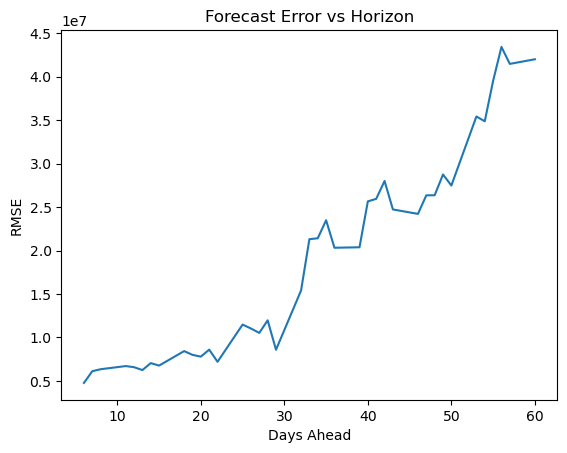

In [39]:
plt.figure()
plt.plot(df_p['horizon'].dt.days, df_p['rmse'])
plt.xlabel("Days Ahead")
plt.ylabel("RMSE")
plt.title("Forecast Error vs Horizon")
plt.show()

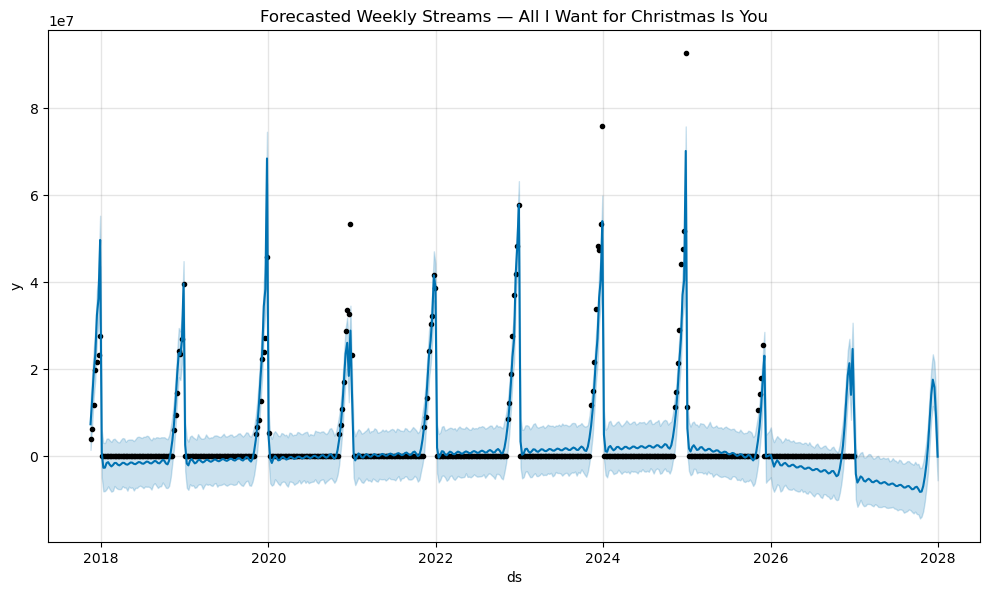

In [41]:
# Forecasting for 2026

future = model.make_future_dataframe(
    periods=52,
    freq='W-THU'
)

forecast = model.predict(future)

model.plot(forecast)
plt.title(f"Forecasted Weekly Streams — {song}")
plt.show()